In [71]:
import qiskit
import qiskit.circuit
import autograd.numpy as np
from qiskit import execute, Aer
from qiskit.circuit import Parameter, QuantumCircuit
import math

I am doing the task 2 for the screening tasks. I am using qiskit quantum simulator. This task requires me to train a quantum circuit that will return |01> and |10> with equal ability. In order to do this task, I first design a quantum circuit that exactly has this function. Now, all the thing I need to do is to change the Pauli-X or Pauli-Y gates to Rotation-X or Rotation-Y gates, and start a traning

In [16]:
circuit_sample=QuantumCircuit(2,1)
circuit_sample.x(0)
circuit_sample.y(0)
circuit_sample.ry(np.pi/2,0)
circuit_sample.cnot(0,1)
circuit_sample.x(1)
circuit_sample.draw()

First, we build the training model and initialize training parameters

In [72]:
theta=[Parameter('A'),Parameter('B'),Parameter('C')]
circuit=QuantumCircuit(2)
circuit.rx(theta[0],0)
circuit.ry(theta[1],0)
circuit.cnot(0,1)
circuit.rx(theta[2],1)
circuit.draw()

Then, we can execute this circuit to get the loss function for gradient descent. The optimization part is done with pennylane package.

In [2]:
import pennylane as qml
from pennylane.devices.default_qubit import DefaultQubit

At first, we implement our circuit above in pennylane. This circuit function will input a parameter vector and return the probability of each state after executing this circuit.

In [43]:
dev = qml.device('default.qubit', wires=2)
def quantum_function(theta):
    qml.RX(theta[0],wires=0)
    qml.RY(theta[1],wires=0)
    qml.CNOT(wires=[0,1])
    qml.RY(theta[2],wires=1)
    return qml.probs(wires=[0,1])

We hope the output probability for each state to be [0,0.5,0.5,0]. So, a natural cost function will be the norm bewteen output probability to the desired probability vector

In [69]:
circuit1 = qml.QNode(quantum_function, dev)
def cost(theta):
    return np.linalg.norm([0,0.5,0.5,0]-circuit1(theta))

Then, we can start a Gradient descent optimization to find the best angle.

In [60]:
opt=qml.GradientDescentOptimizer(stepsize=0.1)
steps = 100
params=np.random.rand(3)

In [62]:
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)

In [67]:
params

array([1.57079633, 1.40479978, 3.07706062])

In [70]:
circuit1(params)

array([0.00052037, 0.49947963, 0.49947963, 0.00052037])

Once we have the angle, we can start a simulation process on qiskit. The qiskit provides a good circuit simulator

In [114]:
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.providers.aer.noise import NoiseModel
simulator = Aer.get_backend('qasm_simulator')

In [91]:
circuit=QuantumCircuit(2,2)
circuit.rx(params[0],0)
circuit.ry(params[1],0)
circuit.cnot(0,1)
circuit.rx(params[2],1)
circuit.measure([0,1],[0,1])
circuit.draw()

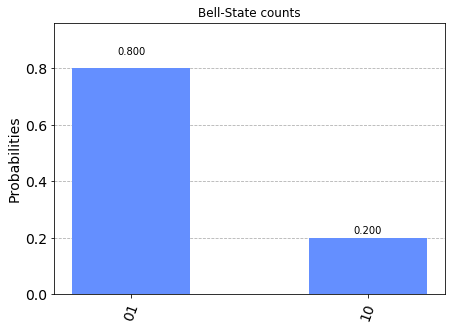

In [118]:
'for 10 counts'
result = execute(circuit, simulator,shots=10).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Bell-State counts')

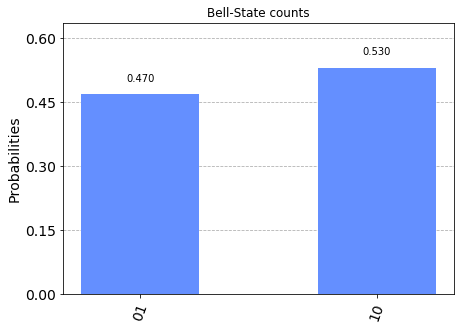

In [119]:
'for 100 counts'
result = execute(circuit, simulator,shots=100).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Bell-State counts')

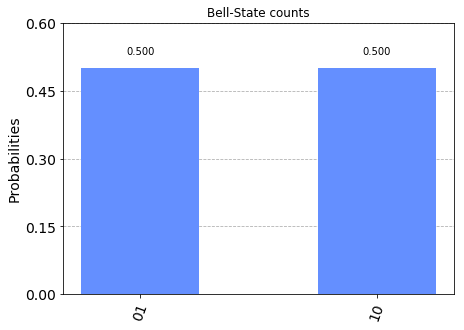

In [120]:
'for 1000 counts'
result = execute(circuit, simulator,shots=1000).result()
counts = result.get_counts(circuit)
plot_histogram(counts, title='Bell-State counts')